<a href="https://colab.research.google.com/github/calibretaliation/DeepLearning20211/blob/main/siamese_net_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!git clone https://github.com/calibretaliation/DeepLearning20211.git

Cloning into 'DeepLearning20211'...
remote: Enumerating objects: 32565, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 32565 (delta 57), reused 0 (delta 0), pack-reused 32466
Receiving objects: 100% (32565/32565), 1.68 GiB | 13.78 MiB/s, done.
Resolving deltas: 100% (115/115), done.
Checking out files: 100% (32428/32428), done.


## Import

In [6]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-xc1i313t
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-xc1i313t


In [7]:
#@title Import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import math
import random

import os
import pickle

import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications, layers, losses, optimizers, metrics, Model, callbacks
from tensorflow.keras.applications import resnet, mobilenet_v3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD


from pathlib import Path

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [8]:
#@title Load CSV

train_df = pd.read_csv('DeepLearning20211/data/train.csv')
test_df = pd.read_csv('DeepLearning20211/data/test.csv')

train_img_dir = Path('DeepLearning20211/data/train_images')
test_img_dir = Path('DeepLearning20211/data/test_images/')

# Drop images with duplicated p-hash value 
train_df = train_df.drop_duplicates(subset=['image_phash']).reset_index(drop=True)

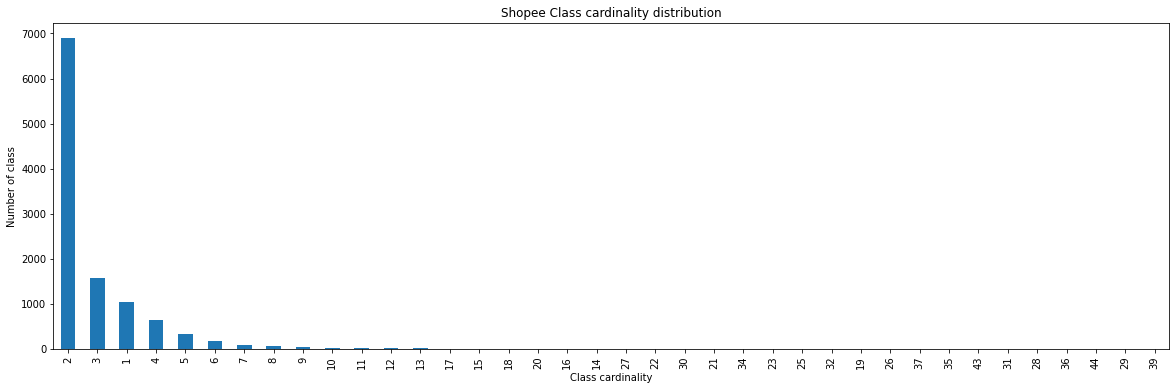

In [10]:
#@title Plot class cardinality distribution

# calculate number of images in each class
label_count = train_df['label_group'].value_counts()

plt.figure(figsize=(20, 6))
label_count.value_counts().plot.bar()
plt.xlabel('Class cardinality')
plt.ylabel('Number of class')
plt.title('Shopee Class cardinality distribution')
plt.show()

## Prepare dataset

In [12]:
#@title Take one instance in each class as anchor

set_seed(42)
anchor_df = train_df.groupby('label_group').nth(0)

In [11]:
#@title Create validation set
val_df = train_df.sample(frac=1, random_state=14).groupby('label_group').nth(0)
val_df['label_group'] = val_df.index
val_df = val_df.reset_index(drop=True)

In [13]:
num_triplets = 200

In [14]:
def create_dataset(mode):
    assert mode == 'training' or mode == 'validation', "argument mode should be 'training' or 'validation'" 
    df = train_df if mode == 'training' else val_df

    # container to store image path
    anchor_container = []
    positive_container = []
    negative_container = []

    # for each anchor image, create num_triplets triplets
    for anchor_label in anchor_df.index:
        anchor = anchor_df['image'][anchor_label]

        positive_df = df[df['label_group'] == anchor_label]
        if len(positive_df) > 1:
            positive_df = positive_df[positive_df['image'] != anchor]

        negative_df = df.groupby('label_group').nth(0)
        negative_df['label_group'] = negative_df.index
        negative_df = negative_df.reset_index(drop=True)
        negative_df = negative_df[negative_df['label_group'] != anchor_label]
        for _ in range(num_triplets if mode == 'training' else 3):
            anchor_container.append(str(train_img_dir) + os.sep + anchor)
            positive_container.append(str(train_img_dir) + os.sep + np.squeeze(positive_df.sample(1)['image']))
            negative_container.append(str(train_img_dir) + os.sep + np.squeeze(negative_df.sample(1)['image']))

    return anchor_container, positive_container, negative_container

In [15]:
# train_ds_raw = create_dataset(mode='training')
# val_ds_raw = create_dataset(mode='validation')

In [16]:
# with open('DeepLearning20211/train_ds_raw.pkl', 'wb') as f:
#     pickle.dump(train_ds_raw, f)

# with open('DeepLearning20211/val_ds_raw.pkl', 'wb') as f:
#     pickle.dump(val_ds_raw, f)

In [17]:
# with open('DeepLearning20211/train_ds_raw.pkl', 'rb') as f:
#     train_ds_raw = pickle.load(f)

# with open('DeepLearning20211/val_ds_raw.pkl', 'rb') as f:
#     val_ds_raw = pickle.load(f)

In [18]:
%%time

with open('/content/drive/MyDrive/checkpoint/train_ds_raw.pkl', 'rb') as f:
    train_ds_raw = pickle.load(f)

with open('/content/drive/MyDrive/checkpoint/val_ds_raw.pkl', 'rb') as f:
    val_ds_raw = pickle.load(f)

CPU times: user 1.39 s, sys: 1.18 s, total: 2.57 s
Wall time: 9.91 s


In [19]:
%%time

train_ds = tf.data.Dataset.from_tensor_slices(train_ds_raw)
val_ds = tf.data.Dataset.from_tensor_slices(val_ds_raw)

CPU times: user 21.6 s, sys: 672 ms, total: 22.2 s
Wall time: 22.6 s


In [20]:
resize_and_scale = tf.keras.Sequential(
    [
     tf.keras.layers.Resizing(224, 224, crop_to_aspect_ratio=True),
     tf.keras.layers.Rescaling(1./255)
     ]
)

data_augmentation = tf.keras.Sequential(
    [
     tf.keras.layers.RandomFlip("vertical"),
     tf.keras.layers.RandomRotation(0.2),
     tf.keras.layers.RandomContrast(0.5),
     tf.keras.layers.RandomZoom((-0.2, 0.2)),
     tf.keras.layers.RandomTranslation(0.14, 0.14),
     ]
)

def filepath_to_img(filepath):
    
    img_string = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img_string)

    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (224, 224))


    return img

def configure_dataset(ds, mode):
    assert mode == 'training' or mode == 'validation', "mode should be 'training' or 'validation'" 
    
    if mode == 'training':
        ds = ds.shuffle(buffer_size=20000)
    
    ds = ds.map(lambda a_path, p_path, n_path: (filepath_to_img(a_path), 
                                                filepath_to_img(p_path), 
                                                filepath_to_img(n_path)), 
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(buffer_size=512)


    # if mode == 'validation':        ###############################
    # ds = ds.cache()

    if mode == 'training':
        ds = ds.map(lambda a, p, n: (a, 
                                     data_augmentation(p), 
                                     n), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    
    ds = ds.batch(64)
    
    return ds

train_ds = configure_dataset(train_ds, mode='training')
val_ds = configure_dataset(val_ds, mode='validation')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


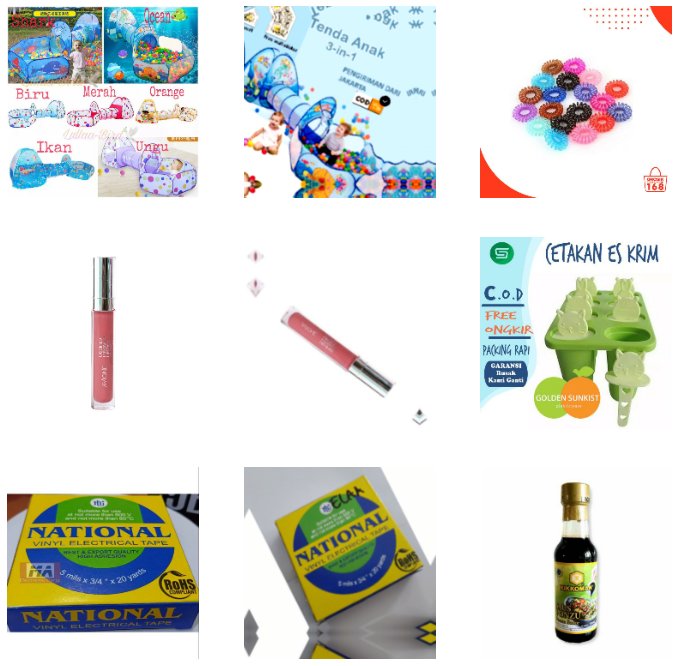

In [21]:
#@title Visualize some triplets

ncols = 3
nrows = 3
plt.figure(figsize=(4*ncols, 4*nrows))
spec = gridspec.GridSpec(ncols=ncols, nrows=nrows)
for anchor_batch, positive_batch, negative_batch in train_ds.take(1):
    i = 0
    for anchor, positive, negative in zip(anchor_batch, positive_batch, negative_batch):
        plt.subplot(spec[ncols*i])
        plt.imshow(anchor)
        plt.axis('off')
        plt.subplot(spec[ncols*i + 1])
        plt.imshow(positive)
        plt.axis('off')
        plt.subplot(spec[ncols*i + 2])
        plt.imshow(negative)
        plt.axis('off')
        
        i += 1
        if i == nrows:
            break
plt.show()

In [22]:
# import shutil
# shutil.rmtree(str(temp_dir), ignore_errors=True)

## Setup model

In [23]:
#@title Define model
base_model = tf.keras.applications.MobileNetV3Large(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

output = layers.Flatten()(base_model.output)
output = layers.Dense(512, activation='relu')(output)
output = layers.BatchNormalization()(output)
output = layers.Dense(256, activation='relu')(output)
output = layers.BatchNormalization()(output)
output = layers.Dense(256, activation='relu')(output)
output = layers.BatchNormalization()(output)

embedding = Model(base_model.input, output, name='Embedding')

trainable = False
for layer in base_model.layers:
    if layer.name == 'multiply_15':
        trainable = True
    layer.trainable = trainable

class Distance(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return ap_distance, an_distance

anchor_input = layers.Input(name='anchor', shape=(224, 224, 3))
positive_input = layers.Input(name='positive', shape=(224, 224, 3))
negative_input = layers.Input(name='negative', shape=(224, 224, 3))

distances = Distance()(
    embedding(mobilenet_v3.preprocess_input(anchor_input)),
    embedding(mobilenet_v3.preprocess_input(positive_input)),
    embedding(mobilenet_v3.preprocess_input(negative_input))
)

siamese_base = Model(
    inputs=[anchor_input, positive_input, negative_input],
    outputs=distances
)

class SiameseNet(Model):
    """
    Siamese network with triplet loss:
        L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """
    def __init__(self, siamese_base, margin=0.5):
        super(SiameseNet, self).__init__()
        self.siamese_base = siamese_base
        self.margin = margin
        self.loss_tracker = metrics.Mean(name='loss')

    def call(self, inputs):
        return self.siamese_base(inputs)

    @tf.function
    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_base(data)
        loss = tf.maximum(ap_distance + self.margin - an_distance, 0.0)
        return loss

    @tf.function
    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_base.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_base.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {'loss': self.loss_tracker.result()}

    @tf.function
    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {'val_loss': self.loss_tracker.result()}

    @property
    def metrics(self):
        # list our metrics here so the `reset_states()` can be called automatically.
        return [self.loss_tracker]



17620992/17605208 [==============================] - 0s 0us/step


In [ ]:
class SaveModelOnBatch(callbacks.Callback):
    def __init__(self, n, path):
        super(SaveModelOnBatch, self).__init__()
        self.n = n
        self.path = path

    def on_batch_end(self, batch, logs=None):
        if batch > 0 and batch % self.n == 0:
            print('Current loss:', logs.get('loss'))
            embedding.save(self.path + os.sep + 'embedding')
            print('embedding saved at', self.path + os.sep + 'embedding')
            siamese_base.save(self.path + os.sep + 'siamese_base')
            print('siamese_base saved at', self.path + os.sep + 'siamese_base')

In [ ]:
model = SiameseNet(siamese_base)
model.compile(optimizer=SGD(learning_rate=1e-5, momentum=0.9, nesterov=True))
model.fit(train_ds, 
          epochs=2, 
          validation_data=val_ds, 
          shuffle=True, 
          callbacks=[SaveModelOnBatch(100, '/content/drive/MyDrive/checkpoint'),
                    #  callbacks.ReduceLROnPlateau(monitor="loss", factor=0.1, patience=1, verbose=1),
                    #  callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1, restore_best_weights=True)
                     ]
)

Epoch 1/2
Current loss: 0.2069600224494934
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
  100/34388 [..............................] - ETA: 20:04:41 - loss: 0.2084Current loss: 0.20800195634365082
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
  200/34388 [..............................] - ETA: 23:41:50 - loss: 0.1976Current loss: 0.19744320213794708
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
  300/34388 [..............................] - ETA: 24:49:14 - loss: 0.1946Current loss: 0.19511651992797852
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
  400/34388 [..............................] - ETA: 25:15:56 - loss: 0.1984Current loss: 0.19842007756233215
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
  500/34388 [..............................] - ETA: 25:30:45 - loss: 0.1976Current loss: 0.19741883873939514
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
  600/34388 [..............................] - ETA: 25:37:19 - loss: 0.1981Current loss: 0.19814862310886383
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
  700/34388 [..............................] - ETA: 25:39:18 - loss: 0.1968Current loss: 0.19675636291503906
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
  800/34388 [..............................] - ETA: 25:40:51 - loss: 0.1952Current loss: 0.19524914026260376
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
  900/34388 [..............................] - ETA: 25:42:31 - loss: 0.1938Current loss: 0.19373227655887604
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 1000/34388 [..............................] - ETA: 25:42:22 - loss: 0.1913Current loss: 0.19133414328098297
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 1100/34388 [..............................] - ETA: 25:41:23 - loss: 0.1889Current loss: 0.1888672262430191
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 1200/34388 [>.............................] - ETA: 25:41:11 - loss: 0.1867Current loss: 0.18665507435798645
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 1300/34388 [>.............................] - ETA: 25:39:23 - loss: 0.1854Current loss: 0.18534435331821442
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 1400/34388 [>.............................] - ETA: 25:36:08 - loss: 0.1842Current loss: 0.1842195689678192
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 1500/34388 [>.............................] - ETA: 25:31:18 - loss: 0.1833Current loss: 0.18321584165096283
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 1600/34388 [>.............................] - ETA: 25:26:44 - loss: 0.1824Current loss: 0.1823626160621643
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 1700/34388 [>.............................] - ETA: 25:22:42 - loss: 0.1818Current loss: 0.18183588981628418
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 1800/34388 [>.............................] - ETA: 25:19:02 - loss: 0.1805Current loss: 0.1804964393377304
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 1900/34388 [>.............................] - ETA: 25:15:44 - loss: 0.1794Current loss: 0.17942792177200317
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 2000/34388 [>.............................] - ETA: 25:12:17 - loss: 0.1778Current loss: 0.1778395175933838
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 2100/34388 [>.............................] - ETA: 25:08:05 - loss: 0.1771Current loss: 0.17706365883350372
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 2200/34388 [>.............................] - ETA: 25:03:57 - loss: 0.1760Current loss: 0.17597509920597076
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 2300/34388 [=>............................] - ETA: 25:02:24 - loss: 0.1749Current loss: 0.17490050196647644
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 2400/34388 [=>............................] - ETA: 24:58:24 - loss: 0.1738Current loss: 0.17379194498062134
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 2500/34388 [=>............................] - ETA: 24:54:39 - loss: 0.1729Current loss: 0.17289355397224426
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 2600/34388 [=>............................] - ETA: 24:50:11 - loss: 0.1720Current loss: 0.1719484180212021
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 2700/34388 [=>............................] - ETA: 24:46:16 - loss: 0.1712Current loss: 0.17116492986679077
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 2800/34388 [=>............................] - ETA: 24:43:25 - loss: 0.1704Current loss: 0.17041093111038208
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 2900/34388 [=>............................] - ETA: 24:39:46 - loss: 0.1690Current loss: 0.16897830367088318
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 3000/34388 [=>............................] - ETA: 24:36:09 - loss: 0.1680Current loss: 0.1679823398590088
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 3100/34388 [=>............................] - ETA: 24:32:36 - loss: 0.1672Current loss: 0.1671387106180191
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 3200/34388 [=>............................] - ETA: 24:28:43 - loss: 0.1661Current loss: 0.16607235372066498
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 3300/34388 [=>............................] - ETA: 24:24:38 - loss: 0.1650Current loss: 0.1650088131427765
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 3400/34388 [=>............................] - ETA: 24:20:30 - loss: 0.1645Current loss: 0.1644781231880188
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 3500/34388 [==>...........................] - ETA: 24:16:08 - loss: 0.1638Current loss: 0.1637357920408249
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 3600/34388 [==>...........................] - ETA: 24:11:50 - loss: 0.1630Current loss: 0.16303734481334686
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 3700/34388 [==>...........................] - ETA: 24:07:50 - loss: 0.1621Current loss: 0.1620795875787735
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 3800/34388 [==>...........................] - ETA: 24:03:53 - loss: 0.1611Current loss: 0.16105017066001892
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 3900/34388 [==>...........................] - ETA: 24:00:18 - loss: 0.1603Current loss: 0.16028138995170593
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 4000/34388 [==>...........................] - ETA: 23:56:35 - loss: 0.1596Current loss: 0.1595742255449295
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 4100/34388 [==>...........................] - ETA: 23:52:45 - loss: 0.1587Current loss: 0.1587304323911667
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 4200/34388 [==>...........................] - ETA: 23:48:24 - loss: 0.1578Current loss: 0.15779812633991241
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 4300/34388 [==>...........................] - ETA: 23:43:58 - loss: 0.1570Current loss: 0.15697909891605377
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 4400/34388 [==>...........................] - ETA: 23:39:39 - loss: 0.1561Current loss: 0.15604852139949799
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 4500/34388 [==>...........................] - ETA: 23:35:24 - loss: 0.1554Current loss: 0.15540070831775665
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 4600/34388 [===>..........................] - ETA: 23:31:17 - loss: 0.1545Current loss: 0.15448716282844543
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 4700/34388 [===>..........................] - ETA: 23:27:15 - loss: 0.1535Current loss: 0.15351036190986633
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 4800/34388 [===>..........................] - ETA: 23:23:26 - loss: 0.1527Current loss: 0.15267618000507355
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 4900/34388 [===>..........................] - ETA: 23:20:55 - loss: 0.1519Current loss: 0.15192759037017822
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 5000/34388 [===>..........................] - ETA: 23:18:10 - loss: 0.1510Current loss: 0.15102067589759827
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 5100/34388 [===>..........................] - ETA: 23:15:12 - loss: 0.1503Current loss: 0.15033213794231415
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 5200/34388 [===>..........................] - ETA: 23:13:07 - loss: 0.1496Current loss: 0.14954178035259247
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 5300/34388 [===>..........................] - ETA: 23:10:16 - loss: 0.1488Current loss: 0.14880964159965515
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 5400/34388 [===>..........................] - ETA: 23:06:54 - loss: 0.1481Current loss: 0.14809533953666687
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 5500/34388 [===>..........................] - ETA: 23:03:36 - loss: 0.1473Current loss: 0.14733155071735382
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 5600/34388 [===>..........................] - ETA: 23:00:25 - loss: 0.1468Current loss: 0.14680352807044983
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 5700/34388 [===>..........................] - ETA: 22:57:19 - loss: 0.1463Current loss: 0.146290123462677
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 5800/34388 [====>.........................] - ETA: 22:53:55 - loss: 0.1460Current loss: 0.1460191309452057
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 5900/34388 [====>.........................] - ETA: 22:50:29 - loss: 0.1455Current loss: 0.1455223113298416
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 6000/34388 [====>.........................] - ETA: 22:47:02 - loss: 0.1449Current loss: 0.144899383187294
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 6100/34388 [====>.........................] - ETA: 22:43:34 - loss: 0.1443Current loss: 0.14431533217430115
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/embedding/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


embedding saved at /content/drive/MyDrive/checkpoint/embedding
INFO:tensorflow:Assets written to: /content/drive/MyDrive/checkpoint/siamese_base/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


siamese_base saved at /content/drive/MyDrive/checkpoint/siamese_base
 6123/34388 [====>.........................] - ETA: 22:47:22 - loss: 0.1442

batch = 64 hội tụ nhanh hơn 32

In [ ]:
embedding.save('/content/drive/MyDrive/checkpoint/embedding')

In [23]:
embedding = tf.keras.models.load_model('/content/drive/MyDrive/checkpoint/embedding_0')

In [116]:
%%time

anchor_paths = (str(train_img_dir) + os.sep + anchor_df['image']).to_list()
anchor_label_group = anchor_df.index.to_list()

anchor_embedding = embedding.predict(
    mobilenet_v3.preprocess_input(
        tf.data.Dataset.from_tensor_slices(anchor_paths).map(
            filepath_to_img, num_parallel_calls=tf.data.AUTOTUNE
            ).prefetch(buffer_size=512).batch(32)
    )
)

anchor_embedding = tf.data.Dataset.from_tensor_slices(anchor_embedding)

CPU times: user 7.32 ms, sys: 18 µs, total: 7.34 ms
Wall time: 7.54 ms


In [ ]:
label_group_to_anchor_index = np.vectorize(lambda label_group: anchor_label_group.index(label_group))

In [ ]:
%%time

val_label_group = val_df['label_group']
val_embedding = embedding.predict(
    mobilenet_v3.preprocess_input(
        tf.data.Dataset.from_tensor_slices((str(train_img_dir) + os.sep +  val_df['image']).to_list()
        ).map(filepath_to_img, num_parallel_calls=tf.data.AUTOTUNE
            # ).map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE
                    ).batch(32)
    )
)



In [111]:
#                                                                                                             val_embedding
test_ds = tf.data.Dataset.from_tensor_slices((label_group_to_anchor_index(val_label_group), np.random.randn(11004, 256).astype(np.float32)))

test_ds.map(lambda label_index, embedding_vector: (label_index, anchor_embedding.map(lambda anchor_vec: 1/tf.reduce_sum(tf.square(anchor_vec - embedding_vector))))).batch(32)

acc = metrics.SparseCategoricalAccuracy()

for l, e in test_ds:
    acc.update_state(l, e)
    

In [ ]:
#@title Old train_model function

def train_model(model, optimizer, max_epochs, reduce_lr_patience, early_stop_patience, checkpoint_name):

    callbacks = [
                 tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=reduce_lr_patience, verbose=1),
                 tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_patience, verbose=1),
                #  tf.keras.callbacks.TensorBoard(logdir/model.name)
                ]
    if checkpoint_name is not None:
        callbacks.append(tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/checkpoint/{}.hdf5'.format(checkpoint_name), monitor='val_loss', verbose=1, save_best_only=True))
    
    # shutil.rmtree(logdir/name, ignore_errors=True)     

    new_model = True
    if model.name in histories.keys() and input("'{}' already exists. Override? [y/n] ".format(model.name)) != 'y':
        new_model = False
    
    set_seed()

    if new_model:
        model.compile(
            optimizer=optimizer,
        )
        histories[model.name] = model.fit(
            train_ds,
            steps_per_epoch=train_ds.cardinality().numpy(),     ############### <----- numpy() to avoid error
            epochs=max_epochs,
            validation_data=val_ds,
            callbacks=callbacks,
            shuffle=True
        )
        epoch_record[model.name] = [histories[model.name].epoch[-1]]

    else:
        model.optimizer.learning_rate.assign(optimizer.get_config()['learning_rate'])
        cont_history = model.fit(
            train_ds, 
            steps_per_epoch=train_ds.cardinality().numpy(),     ############### <----- numpy() to avoid error
            epochs=max_epochs,     
            validation_data=val_ds,    
            callbacks=callbacks,
            initial_epoch=histories[model.name].epoch[-1] + 1,
            shuffle=True
        )
        epoch_record[model.name].append(cont_history.epoch[-1])
        histories[model.name].epoch += cont_history.epoch
        histories[model.name].history['loss'] += cont_history.history['loss']
        histories[model.name].history['val_loss'] += cont_history.history['val_loss']

    return model.name


plotter = tfdocs.plots.HistoryPlotter( 
    # metric = 'nonregu_mae',
    # smoothing_std=10
)

## Depricated

In [ ]:
#@title Depricated

min_cardinality = 4
max_cardinality = label_count.max()         # 39 in this dataset
augmented_list = []

progress = 0
for i in range(len(train_df)):
    # ten file: train_df.iloc[i]['image']
    # label_count[train_df.iloc[i]['label_group']]
    label_group = train_df.iloc[i]['label_group']
    class_cardinality = label_count[label_group]
    if class_cardinality < min_cardinality:
        progress += 1
        print(progress)
        img = image.load_img(train_img_dir/train_df.iloc[i]['image'])
        img = image.img_to_array(img)
        num_augmentation = math.ceil((min_cardinality - class_cardinality) / class_cardinality)
        for _ in range(num_augmentation):
            name = train_df.iloc[i]['image'][:-4] + '_AUGMENTED_' + str(_) + '.jpg'
            augmented_img = data_augmentation(img)
            image.save_img(train_img_dir/name, augmented_img)
            augmented_list.append({'image': name, 'label_group': label_group})


In [ ]:
augmented_train_df = train_df.append(augmented_list, ignore_index=True)

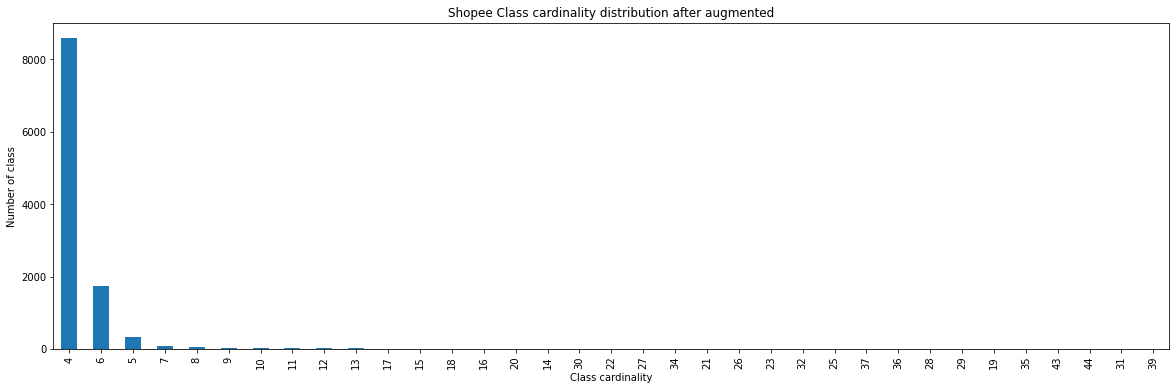

In [ ]:
#@title Plot class cardinality distribution after augmentation

# calculate number of images in each class
augmented_label_count = augmented_train_df['label_group'].value_counts()

plt.figure(figsize=(20, 6))
augmented_label_count.value_counts().plot.bar()
plt.xlabel('Class cardinality')
plt.ylabel('Number of class')
plt.title('Shopee Class cardinality distribution after augmented')
plt.show()